## Great Barrier Reef - Training Script

Downloads the specified branch of the repo from the github and can run the training or even a full parameter sweep.

In [1]:
#@title Select your options

user = "stuttgartteam8" #@param ["stuttgartteam8", "david", "nick"]
branch_name = "GBR_starfish_detection"    #@param {type:"string"}
full_dataset = True    #@param {type:"boolean"}

In [2]:
!nvidia-smi

Wed Dec 29 20:56:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# download dataset
#%%capture
%cd /content/
# images 0-478 (part of whole data set)
if full_dataset:
    !gdown https://drive.google.com/uc?id=1DW2CJja9n8d0Bub-jmJZvnKXAHrpYLkv
    !unzip -u "/content/GBR_dataset.zip" -d "/content/";
else:
    !gdown https://drive.google.com/uc?id=1nVROGC31eVwThW7xYUM8zuxlmQVgC9xr
    !unzip -u "/content/GBR_dataset_partial.zip" -d "/content/";

/content
Downloading...
From: https://drive.google.com/uc?id=1DW2CJja9n8d0Bub-jmJZvnKXAHrpYLkv
To: /content/GBR_dataset.zip
 61% 9.30G/15.2G [01:38<01:08, 86.7MB/s]

In [4]:
# delete existing repo to ensure the newest is fetched from github 
% cd /
!rm -r /content/dl-lab-21w-team08

/


In [5]:
# delete existing repo to ensure the newest is fetched from github 
% cd /
!rm -r /content/dl-lab-21w-team08

# downlhttps://drive.google.com/uc?id=1nVROGC31eVwThW7xYUM8zuxlmQVgC9xroad repo
# %%capture
%cd /content/
#if user == "david":
git_access_token = "28fdd19659f4a0e5bcaf16dd820e5c68bed91102"

# !git clone https://28fdd19659f4a0e5bcaf16dd820e5c68bed91102@github.tik.uni-stuttgart.de/iss/dl-lab-21w-team08.git
clone_comand = f"git clone --single-branch --branch {branch_name} https://{git_access_token}@github.tik.uni-stuttgart.de/iss/dl-lab-21w-team08.git"
!$clone_comand

/
rm: cannot remove '/content/dl-lab-21w-team08': No such file or directory
/content
Cloning into 'dl-lab-21w-team08'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 363 (delta 54), reused 46 (delta 25), pack-reused 287
Receiving objects: 100% (363/363), 5.88 MiB | 2.71 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [6]:
# install dependencies
%%capture
!pip install wandb
!pip install tensorflow_addons
#!pip install gin-config

In [7]:
%%capture out
# run training script
# 37262d20054e8dbf092705158103cd02e31691d6
%cd /content/
!mkdir wandb
%cd /content/dl-lab-21w-team08/GBR_starfish_detection/
if user == "stuttgartteam8":
    !wandb login 37262d20054e8dbf092705158103cd02e31691d6
elif "david":
    !wandb login 37262d20054e8dbf092705158103cd02e31691d6
elif user == "nick":
    !wandb login e9d83c342bbf06922fa978a0d9a92ed847bf4f3e

In [11]:
if full_dataset:
    !python main.py -p="/content/GBR_dataset/"
else:
    !python main.py -p="/content/GBR_dataset_partial/"

wandb: Currently logged in as: davidu (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.9
wandb: Syncing run vibrant-dream-13
wandb: ⭐️ View project at https://wandb.ai/stuttgartteam8/protect_gbr
wandb: 🚀 View run at https://wandb.ai/stuttgartteam8/protect_gbr/runs/1khez299
wandb: Run data is saved locally in /content/dl-lab-21w-team08/GBR_starfish_detection/wandb/run-20211229_160307-1khez299
wandb: Run `wandb offline` to turn off syncing.

    video_id  ...                                        annotations
20         0  ...  [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]
21         0  ...  [{'x': 550, 'y': 214, 'width': 50, 'height': 32}]
22         0  ...  [{'x': 538, 'y': 209, 'width': 56, 'height': 47}]
23         0  ...  [{'x': 535, 'y': 207, 'width': 58, 'height': 48}]
24         0  ...  [{'x': 532, 'y': 205, 'width': 59, 'height': 49}]

[5 rows x 6 columns]
2021-12-29 16:03:11.839040: W tensorflow/core/common_runtime/gpu/gpu_bfc_alloc

In [13]:
%cd /content/dl-lab-21w-team08/GBR_starfish_detection/
import wandb
import tensorflow as tf
from input import load, annotate_image

wandb.init(project="protect_gbr", entity="stuttgartteam8", mode="disabled") 
if full_dataset:
    arg_update = {"data_dir": "/content/GBR_dataset/"}
else:
    arg_update = {"data_dir": "/content/GBR_dataset_partial/"}
wandb.config.update(arg_update, allow_val_change=True)
config = wandb.config


ds_train, ds_val, ds_test = load(config)

print("Download model:")
api = wandb.Api()
run = api.run("stuttgartteam8/protect_gbr/1khez299")
run.file("model.h5").download(replace=True)

print("Load model:")
model = tf.keras.models.load_model('model.h5', compile=False) 
print(model.summary())



/content/dl-lab-21w-team08/GBR_starfish_detection
    video_id  ...                                        annotations
20         0  ...  [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]
21         0  ...  [{'x': 550, 'y': 214, 'width': 50, 'height': 32}]
22         0  ...  [{'x': 538, 'y': 209, 'width': 56, 'height': 47}]
23         0  ...  [{'x': 535, 'y': 207, 'width': 58, 'height': 48}]
24         0  ...  [{'x': 532, 'y': 205, 'width': 59, 'height': 49}]

[5 rows x 6 columns]
Download model:
Load model:
Model: "yolo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 448, 448, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 448, 448, 3)      0         
 licingOpL

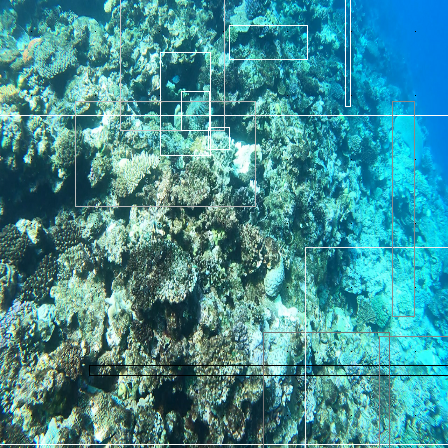

In [21]:

import tensorflow.keras as keras
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

for x,y in ds_train:
    y_pred = model.predict(x)
    img = annotate_image(config, x[0], y_pred[0], y[0])
    img = img.numpy()*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2_imshow(img)